In [83]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot(results_dir, graphs=False, confusion_matrix=False):
    data_list = []

    # Loop through each file in the directory
    for filename in os.listdir(results_dir):
        if filename.endswith('.json'):
            # Load the data from the JSON file
            with open(os.path.join(results_dir, filename), 'r') as file:
                data = json.load(file)

            model_id = data['model_id']
            train_acc_list = data.get('train_accuracy', None)
            train_loss_list = data.get('train_loss', None)
            val_acc_list = data.get('val_accuracy', None)
            val_loss_list = data.get('val_loss', None)
            best_val_acc = data['results'].get('best_acc', None)
            best_epoch = data['results'].get('best_acc_epoch', None)
            cm = np.array(data['results'].get('confusion_matrix', [])) if 'confusion_matrix' in data['results'] else None

            # Extract hyperparameters if available, otherwise set as None
            lr = data['hyperparameters'].get('learning_rate', None)
            epochs = data['hyperparameters'].get('num_epochs', None)
            batch_size = data['hyperparameters'].get('batch_size', None)
            max_len = data['hyperparameters'].get('max_len', None)
            stem_v = data['hyperparameters'].get('stem_v', None)
            pool_v = data['hyperparameters'].get('pool_v', None)
            norm_v = data['hyperparameters'].get('norm_v', None)
            dropout_rate = data['hyperparameters'].get('dropout_rate', None)
            dr = data['hyperparameters'].get('dropout', None)

            row_data = {
                'model_id': model_id,
                'learning_rate': lr,
                'num_epochs': epochs,
                'batch_size': batch_size,
                'max_len': max_len,
                'best_epoch':best_epoch,
                'stem_v':stem_v,
                'pool_v':pool_v, 
                'norm_v': norm_v, 
                'dropout_rate': dropout_rate,
                'dr': dr,
                'best_val_accuracy': best_val_acc,
            }

            data_list.append(row_data)
            if confusion_matrix:
                # Plot the confusion matrix
                disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                disp.plot()
                plt.title(f'Confusion Matrix for Model {model_id}')
                plt.show()

                # Print the classification report
                report = data['results']['classification_report']
                print(f'Classification Report for Model {model_id}:')
                print(report)

            if graphs:            
                fig, ax = plt.subplots()
                ax.plot(train_acc_list, label='Training Accuracy')
                ax.plot(val_acc_list, label='Validation Accuracy')
                ax.set_xlabel('Epoch')
                ax.set_ylabel('Accuracy')
                ax.set_title(f'Accuracy for lr {lr}, batch size {batch_size}, max len {max_len}, best ac: {best_val_acc:.2f}')
                ax.legend()
                ax.set_ylim(0, 1)  # Set y-axis limits from 0 to 1 for accuracy

                # Add faint grid
                ax.set_axisbelow(True)
                ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)
                # Display best accuracy in a box on the graph
                best_acc_text = f'Best Accuracy: {best_val_acc:.2f}'
                plt.text(0.05, 0.95, best_acc_text, transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))

                # Plot the training and validation loss
                plt.figure()
                plt.plot(train_loss_list, label='Training Loss')
                plt.plot(val_loss_list, label='Validation Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title(f'Loss for Model {model_id}')
                plt.legend()
                plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)  # Add faint grid
                plt.ylim(0, 1)  # Set y-axis limits from 0 to 1 for accuracy
                plt.tight_layout()
                plt.show()
                
    df = pd.DataFrame(data_list)
    df.set_index('model_id', inplace=True)
    df = df.sort_values('best_val_accuracy', ascending=False)
    return df


def style_df(df):
    def highlight_max(s):
        is_max = s == s.max()
        return ['background-color: yellow' if v else '' for v in is_max]

    styled_df = df.style.apply(highlight_max, subset=['best_val_accuracy'])
    return styled_df


In [84]:
bert_bin = './results/bert_binary'
bert_multi = './results/bert_multi'

bert_seq_bin = './results/bert4seq_binary'
bert_seq_mult = './results/bert4seq_multi'

w2v_bin = './results/w2v_binary'
w2v_seq = './results/w2v_multi'

In [85]:
style_df(plot(bert_bin,graphs=False, confusion_matrix=False))

,learning_rate,num_epochs,batch_size,max_len,best_epoch,stem_v,pool_v,norm_v,dropout_rate,dr,best_val_accuracy
model_id,,,,,,,,,,,
f4d6adf0-1def-4605-b5bf-49b731660fc3,0.000005,24,50,150,17,None,None,None,None,None,0.839063
97fd9ca1-e6ec-4090-acd6-e40911ff687c,0.000050,24,80,150,7,None,None,None,None,None,0.800000
b1d59ff0-5297-44b4-a60b-2b9c6704cd39,0.000001,24,50,150,22,None,None,None,None,None,0.795312
119e526c-c646-43ed-a272-348f730e81af,0.000001,40,80,150,37,None,None,None,None,None,0.784375
8d3481ec-85aa-41ea-9174-be8bc42fb5a5,0.000010,24,80,150,17,None,None,None,None,None,0.784375
354aca28-406f-41da-8465-69b55d6dcd8b,0.000000,60,80,150,57,None,None,None,None,None,0.773438
c0887bc9-6387-4643-b0e4-bff6ba08afe9,0.000005,24,80,150,18,None,None,None,None,None,0.768750
54187875-8297-4c6f-98d8-00537301bc38,0.000000,40,80,150,37,None,None,None,None,None,0.745313


In [86]:
style_df(plot(bert_multi, graphs=False, confusion_matrix=False))

,learning_rate,num_epochs,batch_size,max_len,best_epoch,stem_v,pool_v,norm_v,dropout_rate,dr,best_val_accuracy
model_id,,,,,,,,,,,
5e6b1a3c-b12c-4d06-87ef-a90eae819ee4,0.000010,35,25,150,34,None,None,None,None,None,0.669903
8fe23a85-c5f4-4934-8f0a-ffe324d7fdf5,0.000050,35,25,150,32,None,None,None,None,None,0.650485
08840e67-c4cd-46a0-9f9a-aab6a7275813,0.000005,35,25,150,28,None,None,None,None,None,0.640777
ccb211a9-0347-40b8-b7da-b4c325af7a6d,0.000001,60,25,150,54,None,None,None,None,None,0.592233
f0d84600-64be-4066-bb19-d4edbcca443e,0.000001,35,25,150,34,None,None,None,None,None,0.446602


In [87]:
style_df(plot(bert_seq_bin, graphs=False, confusion_matrix=False))

,learning_rate,num_epochs,batch_size,max_len,best_epoch,stem_v,pool_v,norm_v,dropout_rate,dr,best_val_accuracy
model_id,,,,,,,,,,,
42008382-f62d-4129-a8fe-5ac18f4ba56d,0.000005,20,50,150,15,None,None,None,None,0.500000,0.790625
988bcbc7-72ce-400a-9e55-248f2a1b09bf,0.000001,20,50,150,15,None,None,None,None,0.500000,0.787500
d77612be-cd36-49f2-8e66-42ed304d454d,0.000010,10,50,150,8,None,None,None,None,0.500000,0.785937
fb735898-e4d9-43c3-ada6-76a6ef276f7b,0.000005,10,50,150,5,None,None,None,None,0.500000,0.784375
64146dd1-22c1-4c32-8eab-7e7a3f8a1196,0.000001,10,80,150,9,None,None,None,None,0.500000,0.709375


In [88]:
style_df(plot(bert_seq_mult, graphs=False, confusion_matrix=False))

,learning_rate,num_epochs,batch_size,max_len,best_epoch,stem_v,pool_v,norm_v,dropout_rate,dr,best_val_accuracy
model_id,,,,,,,,,,,
3cbf0e25-c54d-4329-9d04-d018c9261647,0.000005,25,25,150,20,None,None,None,None,0.500000,0.660194
84d946fd-72d9-4073-bcb3-19120a7ecb7c,0.000010,25,25,150,13,None,None,None,None,0.500000,0.653722
e0fab39b-7665-46a6-9a8b-9fb3607a780f,0.000001,60,25,150,54,None,None,None,None,0.500000,0.605178
44392080-54c0-4981-8466-c2fbc376eff3,0.000001,25,25,150,24,None,None,None,None,0.500000,0.417476


In [89]:
style_df(plot(w2v_bin, graphs=False, confusion_matrix=False))

,learning_rate,num_epochs,batch_size,max_len,best_epoch,stem_v,pool_v,norm_v,dropout_rate,dr,best_val_accuracy
model_id,,,,,,,,,,,
960c577c-4184-4daf-a8f9-6a0643c7d14a,0.000050,100,100,None,54,False,mean,False,0.500000,None,0.767188
26990702-8e2a-4dba-bb76-b65ce5123845,0.000100,100,100,None,30,False,mean,False,0.500000,None,0.756250
4a82689e-4f27-4399-a4f4-4570b826bf41,0.000100,100,100,None,50,False,mean,False,0.500000,None,0.751563
57632ed8-b33a-46c6-a886-5f13df1a4415,0.000040,100,100,None,88,False,mean,False,0.500000,None,0.751563
139bb5ff-1e59-48a5-a46b-640fc6271d4c,0.000500,100,100,None,80,False,mean,False,0.250000,None,0.750000
2f50045f-9309-40e3-9f68-ba51c4337823,0.000500,50,100,None,18,False,mean,True,0.500000,None,0.750000
da40269a-d34c-406d-a390-11706c844562,0.000500,100,80,None,28,False,mean,False,0.500000,None,0.750000
a6d25cd8-4a7d-47e1-92bf-83427f357a20,0.000500,100,100,None,10,False,mean,False,0.500000,None,0.750000
8cc356d9-0d29-4c0d-80c1-dc5991d35620,0.000500,100,100,None,32,False,mean,False,0.500000,None,0.748437


In [90]:
style_df(plot(w2v_seq, graphs=False, confusion_matrix=False))

,learning_rate,num_epochs,batch_size,max_len,best_epoch,stem_v,pool_v,norm_v,dropout_rate,dr,best_val_accuracy
model_id,,,,,,,,,,,
ab04ff24-a7f9-4c5e-a9f7-f3a876c5b3c1,0.000500,100,128,None,91,False,mean,False,0.500000,None,0.559871
f2a410b8-1880-4172-bd77-ed80c68b3a10,0.000500,100,100,None,33,False,mean,False,0.500000,None,0.550162
a20fe6f0-0e04-4020-825e-8dbe0614c20d,0.000500,100,100,None,49,False,mean,False,0.500000,None,0.550162
cef87d52-ab00-4b14-97a2-c18491f5aa6c,0.000500,100,50,None,35,False,mean,False,0.500000,None,0.550162
bd3662a8-5a6d-4030-a5c3-e4e63092d5a5,0.000500,100,100,None,83,False,mean,False,0.500000,None,0.546926
f5499e87-c02b-4378-9ae7-9347cc4472d8,0.000500,100,8,None,53,False,mean,False,0.500000,None,0.546926
7562eacd-da19-4b63-8227-aff75d3e1a68,0.000500,100,128,None,49,False,mean,False,0.500000,None,0.543689
46ed979b-bac9-4b5a-8c19-eb598514268f,0.000500,100,180,None,49,False,mean,False,0.500000,None,0.543689
a13e8cb2-d226-4f79-b9f2-5ac07a3c57b4,0.000500,100,100,None,44,True,mean,False,0.500000,None,0.543689


In [127]:
import os
import json
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def compile_best_results(results_dir, graph=False, confusion_matrix=False, task='binary'):
    data = []

    # Loop through the subdirectories in the 'results' directory
    for subdir in os.listdir(results_dir):
        if task not in subdir:
            continue
        subdir_path = os.path.join(results_dir, subdir)
        
        # Check if the current item is a directory
        if os.path.isdir(subdir_path):
            best_acc = 0
            best_file = None
            
            # Loop through the JSON files in the subdirectory
            for file in os.listdir(subdir_path):
                if file.endswith(".json"):
                    file_path = os.path.join(subdir_path, file)
                    
                    # Load the JSON data
                    with open(file_path) as f:
                        json_data = json.load(f)
                    
                    # Check if the JSON has the 'results' key
                    if 'results' in json_data:
                        results = json_data['results']
                        
                        # Check if the 'best_acc' key exists and update the best accuracy
                        if 'best_acc' in results and results['best_acc'] > best_acc:
                            best_acc = results['best_acc']
                            best_file = file_path
            
            # If a best file was found, add its data to the list
            if best_file:
                with open(best_file) as f:
                    best_data = json.load(f)
                
                # Extract relevant information from the best-performing model
                model_id = best_data['model_id']
                best_epoch = best_data['results'].get('best_acc_epoch', None)
                
                # Extract hyperparameters if available, otherwise set as None
                lr = best_data['hyperparameters'].get('learning_rate', None)
                epochs = best_data['hyperparameters'].get('num_epochs', None)
                batch_size = best_data['hyperparameters'].get('batch_size', None)
                max_len = best_data['hyperparameters'].get('max_len', None)
                stem_v = best_data['hyperparameters'].get('stem_v', None)
                pool_v = best_data['hyperparameters'].get('pool_v', None)
                norm_v = best_data['hyperparameters'].get('norm_v', None)
                dropout_rate = best_data['hyperparameters'].get('dropout_rate', None)
                dr = best_data['hyperparameters'].get('dropout', None)

                
                # Extract additional information for graphs and confusion matrix
                train_acc_list = best_data.get('train_accuracy', None)
                train_loss_list = best_data.get('train_loss', None)
                val_acc_list = best_data.get('val_accuracy', None)
                val_loss_list = best_data.get('val_loss', None)
                cm = np.array(best_data['results'].get('confusion_matrix', [])) if 'confusion_matrix' in best_data['results'] else None
                
                # Create a dictionary with the extracted information
                row_data = {
                    'model_id': model_id,
                    'subdir': subdir,
                    'learning_rate': lr,
                    'num_epochs': epochs,
                    'batch_size': batch_size,
                    'max_len': max_len,
                    'best_epoch': best_epoch,
                    'stem_v':stem_v,
                    'pool_v':pool_v, 
                    'norm_v': norm_v, 
                    'dropout_rate': dropout_rate,
                    'dr': dr,
                    'best_val_accuracy': best_acc
                }
                
                data.append(row_data)
                print(model_id)
                if confusion_matrix and cm is not None:
                    # Plot the confusion matrix
                    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                    disp.plot()
                    plt.title(f'{subdir}_classifier')
                    plt.show()
                    
                    # Print the classification report
                    report = best_data['results'].get('classification_report', None)
                    if report:
                        print(f'Classification Report for {subdir}  Model {model_id}:')
                        print(report)
                
                if graph and train_acc_list and val_acc_list and train_loss_list and val_loss_list:
                    fig, ax = plt.subplots()
                    ax.plot(train_acc_list, label='Training Accuracy')
                    ax.plot(val_acc_list, label='Validation Accuracy')
                    ax.set_xlabel('Epoch')
                    ax.set_ylabel('Accuracy')
                    ax.set_title(f'Accuracy for lr {lr}, batch size {batch_size}, max len {max_len}, best acc: {best_acc:.2f}')
                    ax.legend()
                    ax.set_ylim(0, 1)  # Set y-axis limits from 0 to 1 for accuracy

                    # Add faint grid
                    ax.set_axisbelow(True)
                    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)
                    # Display best accuracy in a box on the graph
                    best_acc_text = f'Best Accuracy: {best_acc:.2f}'
                    plt.text(0.05, 0.95, best_acc_text, transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))

                    # Plot the training and validation loss
                    plt.figure()
                    plt.plot(train_loss_list, label='Training Loss')
                    plt.plot(val_loss_list, label='Validation Loss')
                    plt.xlabel('Epoch')
                    plt.ylabel('Loss')
                    plt.title(f'Loss for {subdir} Model {model_id}')
                    plt.legend()
                    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)  # Add faint grid
                    plt.ylim(0, 0.02)  # Set y-axis limits from 0 to 1 for accuracy
                    plt.tight_layout()
                    plt.show()
    
    # Create a DataFrame from the compiled data
    df = pd.DataFrame(data)
    df.set_index('model_id', inplace=True)
    
    # Sort the DataFrame by 'best_val_accuracy' in descending order
    df.sort_values(by='best_val_accuracy', ascending=False, inplace=True)
    
    return df

f4d6adf0-1def-4605-b5bf-49b731660fc3


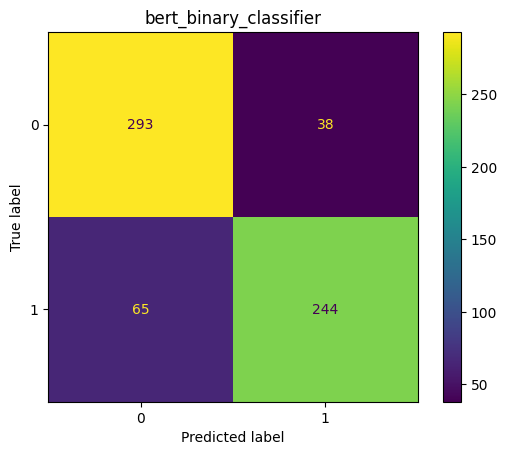

Classification Report for bert_binary  Model f4d6adf0-1def-4605-b5bf-49b731660fc3:
              precision    recall  f1-score   support

     Class 0       0.84      0.84      0.84       331
     Class 1       0.83      0.83      0.83       309

    accuracy                           0.84       640
   macro avg       0.84      0.84      0.84       640
weighted avg       0.84      0.84      0.84       640



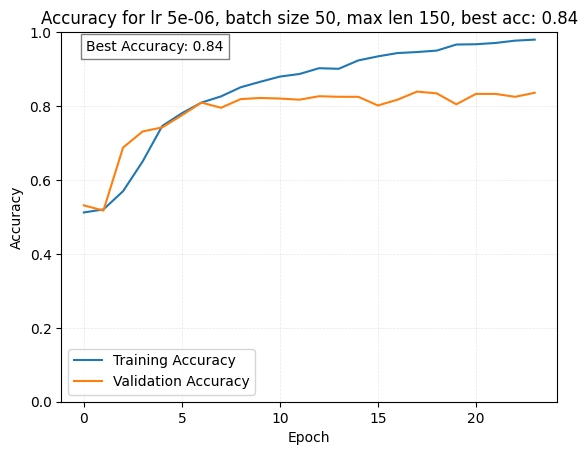

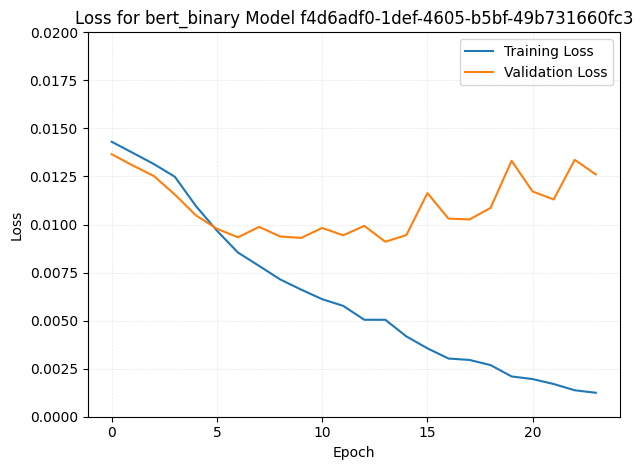

960c577c-4184-4daf-a8f9-6a0643c7d14a


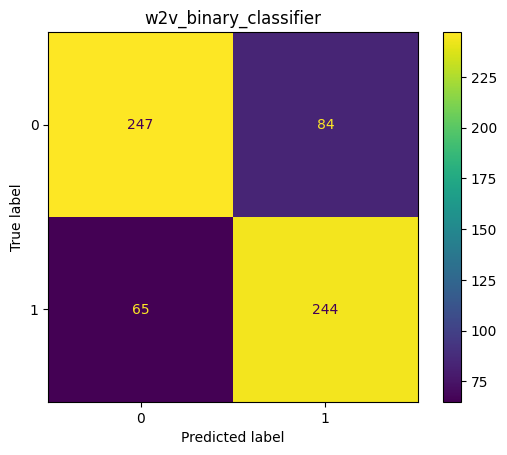

Classification Report for w2v_binary  Model 960c577c-4184-4daf-a8f9-6a0643c7d14a:
              precision    recall  f1-score   support

     class 0       0.79      0.75      0.77       331
     class 1       0.74      0.79      0.77       309

    accuracy                           0.77       640
   macro avg       0.77      0.77      0.77       640
weighted avg       0.77      0.77      0.77       640



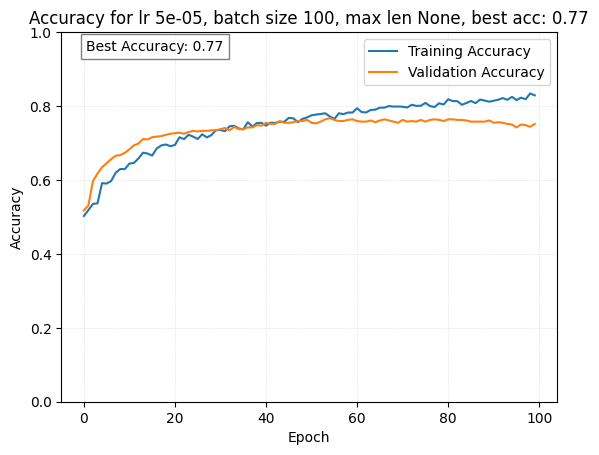

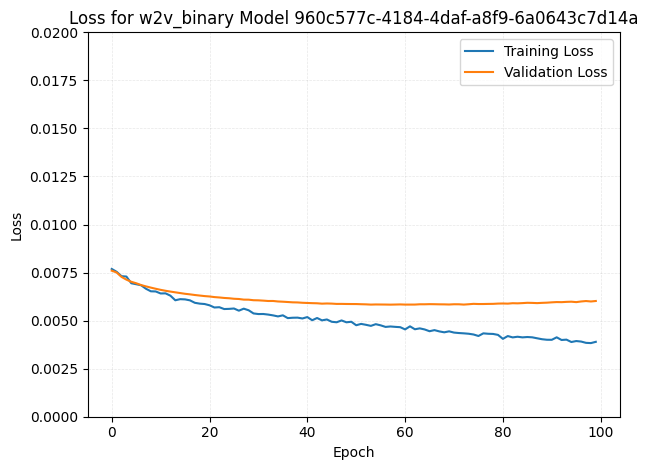

,subdir,learning_rate,num_epochs,batch_size,max_len,best_epoch,stem_v,pool_v,norm_v,dropout_rate,dr,best_val_accuracy
model_id,,,,,,,,,,,,
f4d6adf0-1def-4605-b5bf-49b731660fc3,bert_binary,0.000005,24,50,150.000000,17,None,None,None,nan,None,0.839063
960c577c-4184-4daf-a8f9-6a0643c7d14a,w2v_binary,0.000050,100,100,nan,54,False,mean,False,0.500000,None,0.767188


In [129]:
style_df(compile_best_results('./results', graph=True, confusion_matrix=True, task='binary'))

In [93]:
bert_bin = './results/bert_binary'
bert_multi = './results/bert_multi'

bert_seq_bin = './results/bert4seq_binary'
bert_seq_mult = './results/bert4seq_multi'

w2v_bin = './results/w2v_binary'
w2v_seq = './results/w2v_multi'

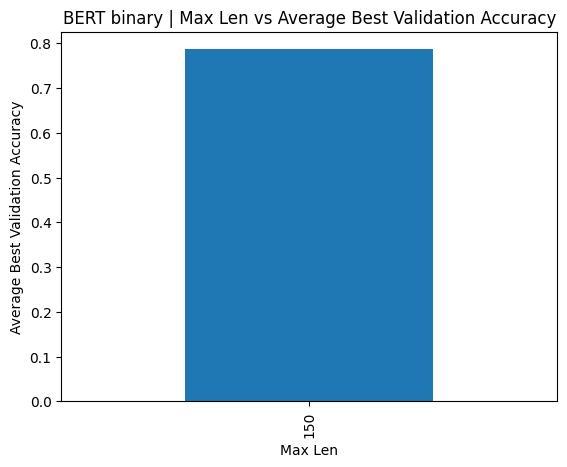

In [111]:
# import matplotlib.pyplot as plt

def plot_bar_chart(df, column, title):
    avg = df.groupby(column)['best_val_accuracy'].mean()
    plt.figure()
    avg.plot(kind='bar')
    plt.xlabel(column.replace('_', ' ').title())
    plt.ylabel('Average Best Validation Accuracy')
    plt.title(f'{title} | {column.replace("_", " ").title()} vs Average Best Validation Accuracy')
    plt.show()

# Example usage
new_df = plot(bert_bin, graphs=False, confusion_matrix=False)

data = 'BERT binary'

# Plot bar charts for various columns
plot_bar_chart(new_df, 'max_len', data)
# plot_bar_chart(new_df, 'batch_size', data)
# plot_bar_chart(new_df, 'learning_rate', data)
# plot_bar_chart(new_df, 'stem_v', data)
# plot_bar_chart(new_df, 'pool_v', data)
# plot_bar_chart(new_df, 'norm_v', data)

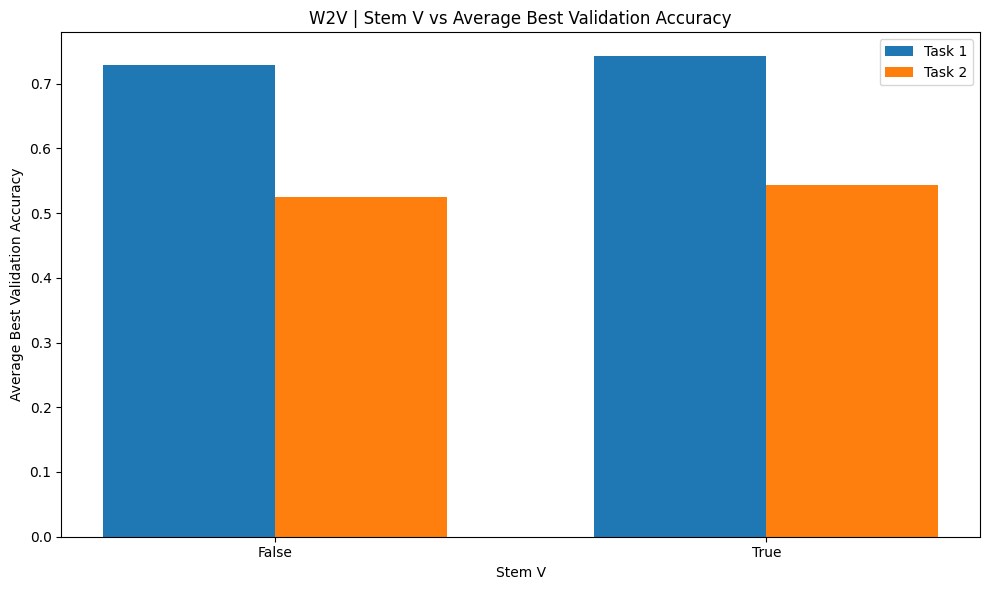

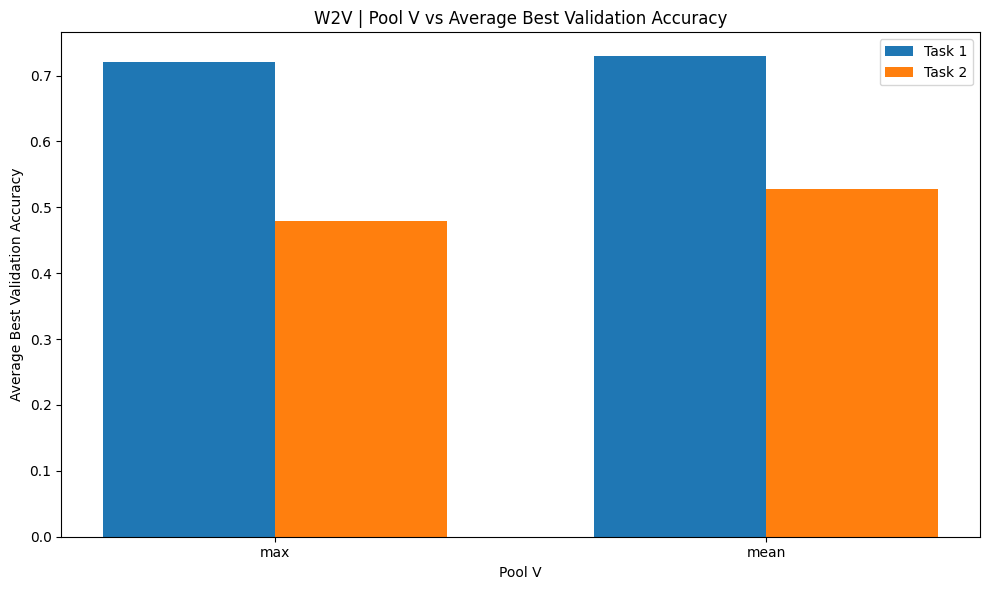

In [110]:
import matplotlib.pyplot as plt

def plot_dual_bar_chart(df_t1, df_t2, column, title):
    avg_t1 = df_t1.groupby(column)['best_val_accuracy'].mean()
    avg_t2 = df_t2.groupby(column)['best_val_accuracy'].mean()

    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    x = np.arange(len(avg_t1))

    plt.bar(x - bar_width / 2, avg_t1, width=bar_width, label='Task 1')
    plt.bar(x + bar_width / 2, avg_t2, width=bar_width, label='Task 2')

    plt.xlabel(column.replace('_', ' ').title())
    plt.ylabel('Average Best Validation Accuracy')
    plt.title(f'{title} | {column.replace("_", " ").title()} vs Average Best Validation Accuracy')

    plt.xticks(x, avg_t1.index)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
new_df_t1 = plot(w2v_bin, graphs=False, confusion_matrix=False)
new_df_t2 = plot(w2v_seq, graphs=False, confusion_matrix=False)
data = 'W2V'

# Plot dual bar charts for various columns
# plot_dual_bar_chart(new_df_t1, new_df_t2, 'batch_size', data)
# plot_dual_bar_chart(new_df_t1, new_df_t2, 'batch_size', data)
# plot_dual_bar_chart(new_df_t1, new_df_t2, 'learning_rate', data)
plot_dual_bar_chart(new_df_t1, new_df_t2, 'stem_v', data)
plot_dual_bar_chart(new_df_t1, new_df_t2, 'pool_v', data)
# plot_dual_bar_chart(new_df_t1, new_df_t2, 'norm_v', data)